## Data Loading of crop_yield


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

prod_df = pd.read_csv('/content/drive/My Drive/RDA/crop_yield.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Rename the 'NAME' column into 'state'
prod_df.rename(columns={'NAME': 'state'}, inplace=True)
# Standardize the rows of state into small letters
prod_df['state'] = prod_df['state'].str.lower()

In [ ]:
# Change datatype of date to 'date'
prod_df['date'] = pd.to_datetime(prod_df['date'])

In [ ]:
# Checking for missing values
print("Missing values per column:")
print(prod_df.isnull().sum())

# Checking for duplicate rows
print("\nNumber of duplicate rows:")
print(prod_df.duplicated().sum())

Missing values per column:
state           0
date            0
crop_type       0
planted_area    0
production      0
dtype: int64

Number of duplicate rows:
0


In [ ]:
# Extract paddy records from the whole dataset
paddy_df = prod_df[prod_df['crop_type'].str.lower() == 'paddy']
paddy_df.head()

,state,date,crop_type,planted_area,production
36,malaysia,2017-01-01,paddy,685548.0,2570513.0
37,malaysia,2018-01-01,paddy,699980.0,2639202.0
38,malaysia,2019-01-01,paddy,672084.0,2352870.0
39,malaysia,2020-01-01,paddy,644908.2,2356391.9
40,malaysia,2021-01-01,paddy,647936.0,2441597.0


Generate dummy data for paddy

In [ ]:
from datetime import datetime
import numpy as np

# Define monthly distribution pattern
monthly_pattern = np.array([
    0.05, 0.05, 0.06, 0.07, 0.08, 0.10,
    0.12, 0.13, 0.12, 0.09, 0.08, 0.05
])

# List to store expanded rows
expanded_data = []

# Iterate over each row
for _, row in paddy_df.iterrows():
    state = row['state']
    # Access the year directly from the datetime object
    year = row['date'].year
    planted_area = row['planted_area']
    total_production = row['production']

    # Skip if no production (like Kuala Lumpur)
    if total_production == 0:
        monthly_production = [0] * 12
    else:
        monthly_production = np.round(total_production * monthly_pattern, 2)

    # Generate 12 rows for each month
    for month in range(1, 13):
        # Format the date correctly
        date = f"{year}-{str(month).zfill(2)}-01"
        expanded_data.append({
            'state': state,
            'date': date,
            'crop_type': 'paddy',
            'planted_area': planted_area,
            'production': monthly_production[month - 1]
        })

# Create new DataFrame using pd.DataFrame
monthly_paddy_df = pd.DataFrame(expanded_data)

print("Monthly dummy dataset created successfully!")

Monthly dummy dataset created successfully!


## Download all the dataset of weather

In [ ]:
import glob
import pandas as pd

def find_header_row(file_path):
    """Find the line number where 'PARAMETER,YEAR' appears"""
    with open(file_path, 'r') as f:
        for idx, line in enumerate(f):
            if line.startswith('PARAMETER,YEAR'):
                return idx
    raise ValueError(f"Header not found in {file_path}")

# List all weather CSV files from Google Drive
weather_files = glob.glob("/content/drive/My Drive/RDA/weather/weather_*.csv") # Updated path and wildcard
weather_all = []

for file in weather_files:
    try:
        # Find where the real header starts
        header_row = find_header_row(file)

        # Read the CSV file, skipping initial lines
        df = pd.read_csv(file, on_bad_lines='skip', header=header_row)

        # Extract state from filename
        state = file.split('_')[1].replace(".csv", "")

        # Melt the DataFrame
        df_melted = df.melt(
            id_vars=["PARAMETER", "YEAR"],
            value_vars=["JAN", "FEB", "MAR", "APR", "MAY", "JUN",
                        "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"],
            var_name="month", value_name="value"
        )

        # Map month names to numbers
        month_map = {
            "JAN": 1, "FEB": 2, "MAR": 3, "APR": 4, "MAY": 5, "JUN": 6,
            "JUL": 7, "AUG": 8, "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12
        }
        df_melted['month_num'] = df_melted['month'].map(month_map)

        # Create date column
        df_melted['date'] = pd.to_datetime(
            dict(year=df_melted['YEAR'], month=df_melted['month_num'], day=1)
        )

        # Pivot the melted DataFrame
        df_pivot = df_melted.pivot_table(
            index="date", columns="PARAMETER", values="value"
        ).reset_index()
        df_pivot.columns.name = None  # Remove pivot table column name

        # Add state information
        df_pivot['state'] = state

        # Append to list
        weather_all.append(df_pivot)

    except Exception as e:
        print(f"❌ Error processing file: {file}")
        print(f"Error details: {e}")

# Final concatenation
if weather_all:
    weather_df_all = pd.concat(weather_all, ignore_index=True)
    print("\n✅ Successfully concatenated all files.")
else:
    print("\n⚠️ No valid files were processed. Output DataFrame is empty.")


✅ Successfully concatenated all files.


## Merge concatenated dataframe with Paddy Production dataframe

In [ ]:
# Ensure the 'date' column in monthly_paddy_df is datetime type
monthly_paddy_df['date'] = pd.to_datetime(monthly_paddy_df['date'])

merged_df = pd.merge(monthly_paddy_df, weather_df_all, on=["state", "date"], how="inner")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# Display descriptive statistics
print("\nDescriptive Statistics:")
print(merged_df.describe())


Descriptive Statistics:
                                date   planted_area     production  \
count                            792     792.000000     792.000000   
mean   2019-12-16 11:19:59.999999744   58006.290909   17435.701869   
min              2017-01-01 00:00:00    2505.000000     375.100000   
25%              2018-06-23 12:00:00   13639.000000    3569.100000   
50%              2019-12-16 12:00:00   41301.500000   11621.850000   
75%              2021-06-08 12:00:00   74972.000000   20997.172500   
max              2022-12-01 00:00:00  214880.000000  124236.060000   
std                              NaN   58854.642639   21931.020390   

       ALLSKY_SFC_LW_DWN  PRECTOTCORR_SUM        RH2M     T2M_MAX     T2M_MIN  
count         792.000000       792.000000  792.000000  792.000000  792.000000  
mean           36.074015       245.210290   84.140215   31.071894   23.565821  
min            33.560000         0.500000   68.580000   27.580000   18.770000  
25%            35.630000

In [ ]:
# Check data types and non-null values
print("\nDataFrame Info:")
merged_df.info()

# Check for missing values
print("\nMissing values per column:")
print(merged_df.isnull().sum())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   state              792 non-null    object        
 1   date               792 non-null    datetime64[ns]
 2   crop_type          792 non-null    object        
 3   planted_area       792 non-null    float64       
 4   production         792 non-null    float64       
 5   ALLSKY_SFC_LW_DWN  792 non-null    float64       
 6   PRECTOTCORR_SUM    792 non-null    float64       
 7   RH2M               792 non-null    float64       
 8   T2M_MAX            792 non-null    float64       
 9   T2M_MIN            792 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 62.0+ KB

Missing values per column:
state                0
date                 0
crop_type            0
planted_area         0
production           0
ALL

In [ ]:
# Check for duplicate rows
print("\nNumber of duplicate rows:")
print(merged_df.duplicated().sum())


Number of duplicate rows:
0


## Exploratory Data Analysis

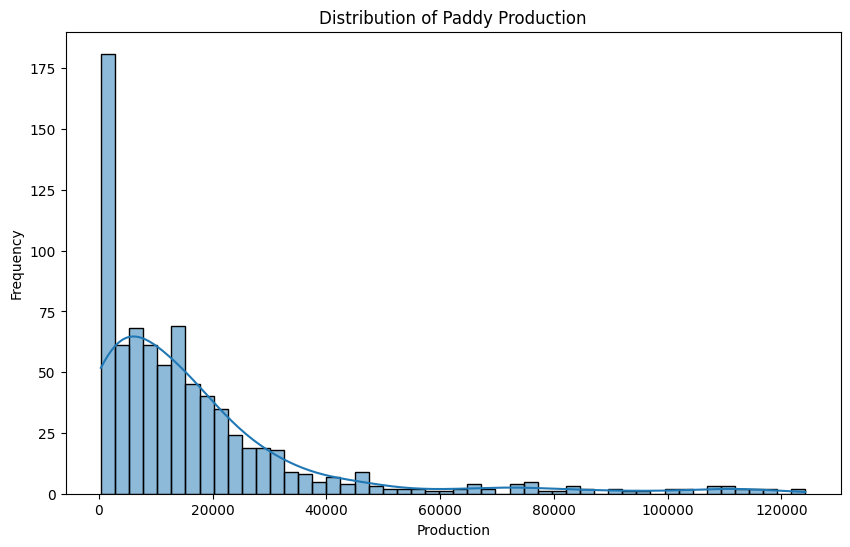

In [ ]:
# Visualize the distribution of 'production'
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['production'], bins=50, kde=True)
plt.title('Distribution of Paddy Production')
plt.xlabel('Production')
plt.ylabel('Frequency')
plt.show()

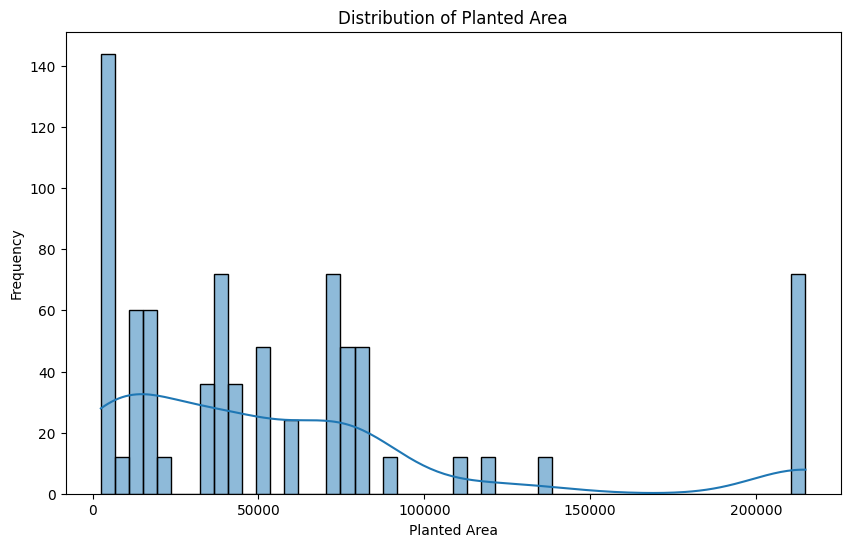

In [ ]:
# Visualize the distribution of 'planted_area'
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['planted_area'], bins=50, kde=True)
plt.title('Distribution of Planted Area')
plt.xlabel('Planted Area')
plt.ylabel('Frequency')
plt.show()

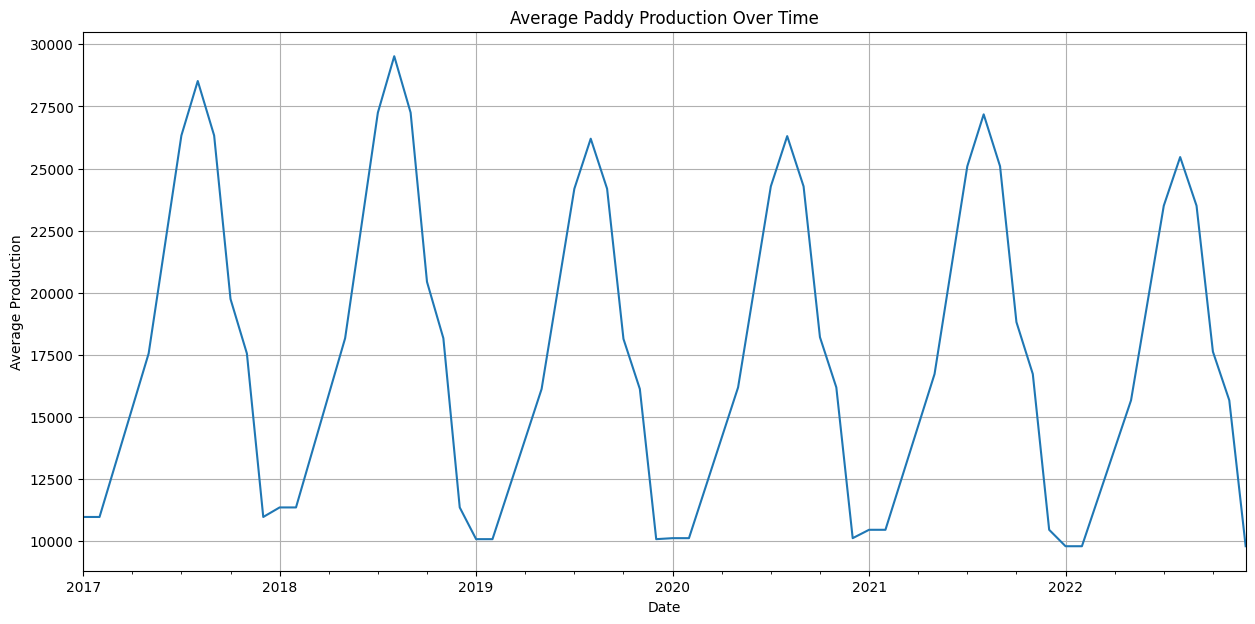

In [ ]:
# Time series plot of average production over time
plt.figure(figsize=(15, 7))
merged_df.groupby('date')['production'].mean().plot()
plt.title('Average Paddy Production Over Time')
plt.xlabel('Date')
plt.ylabel('Average Production')
plt.grid(True)
plt.show()

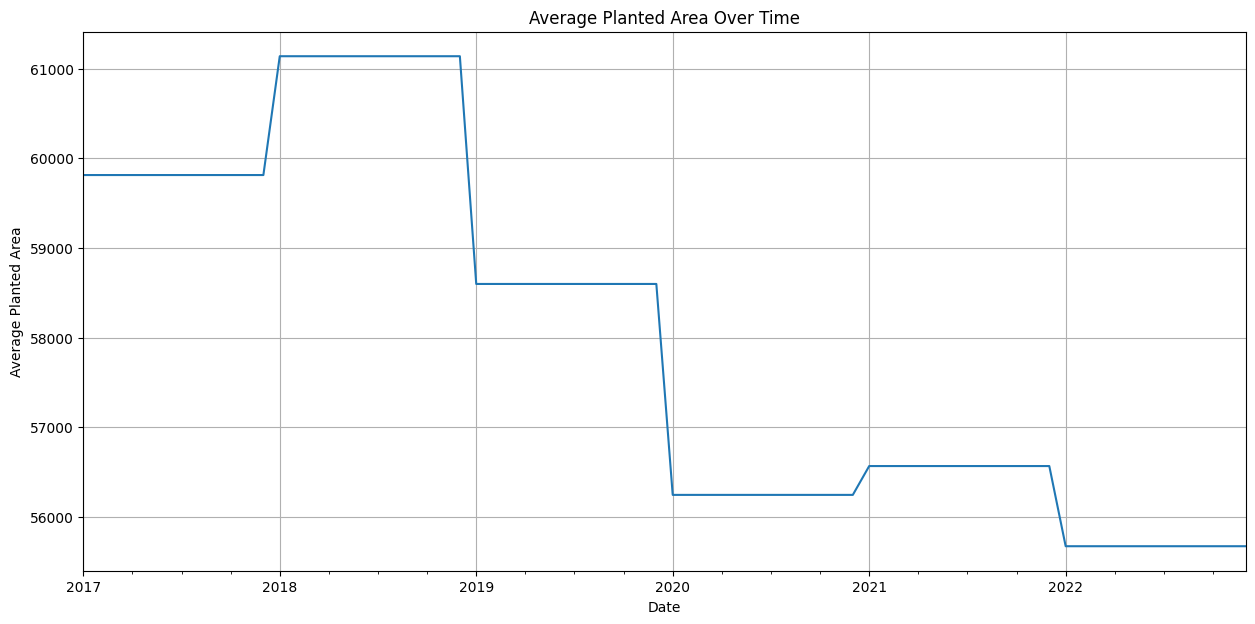

In [ ]:
# Time series plot of average planted area over time
plt.figure(figsize=(15, 7))
merged_df.groupby('date')['planted_area'].mean().plot()
plt.title('Average Planted Area Over Time')
plt.xlabel('Date')
plt.ylabel('Average Planted Area')
plt.grid(True)
plt.show()

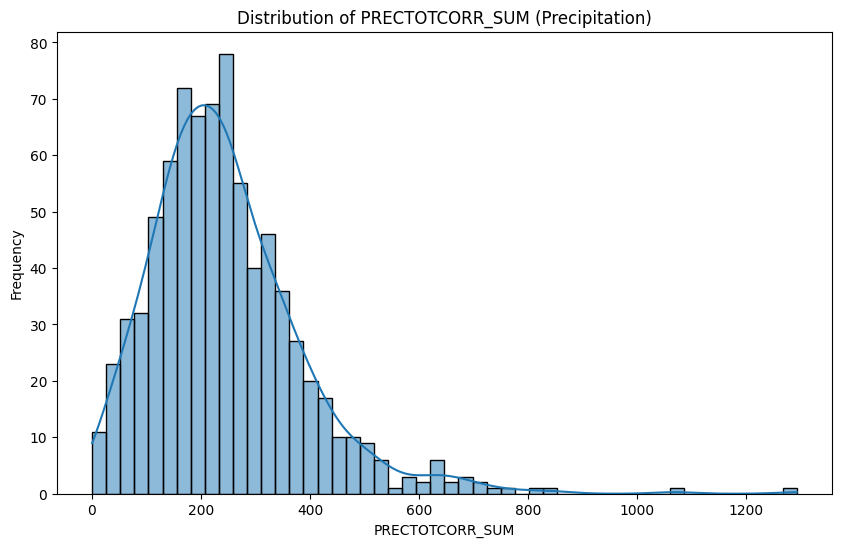

In [ ]:
# Visualize distribution of weather parameters (example: PRECTOTCORR_SUM)
if 'PRECTOTCORR_SUM' in merged_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_df['PRECTOTCORR_SUM'], bins=50, kde=True)
    plt.title('Distribution of PRECTOTCORR_SUM (Precipitation)')
    plt.xlabel('PRECTOTCORR_SUM')
    plt.ylabel('Frequency')
    plt.show()

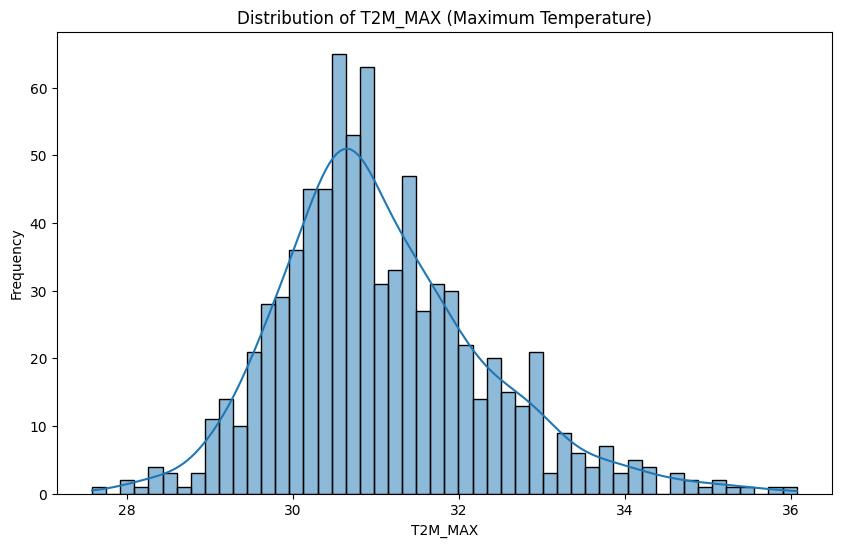

In [ ]:
# Visualize distribution of weather parameters (example: T2M_MAX)
if 'T2M_MAX' in merged_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_df['T2M_MAX'], bins=50, kde=True)
    plt.title('Distribution of T2M_MAX (Maximum Temperature)')
    plt.xlabel('T2M_MAX')
    plt.ylabel('Frequency')
    plt.show()

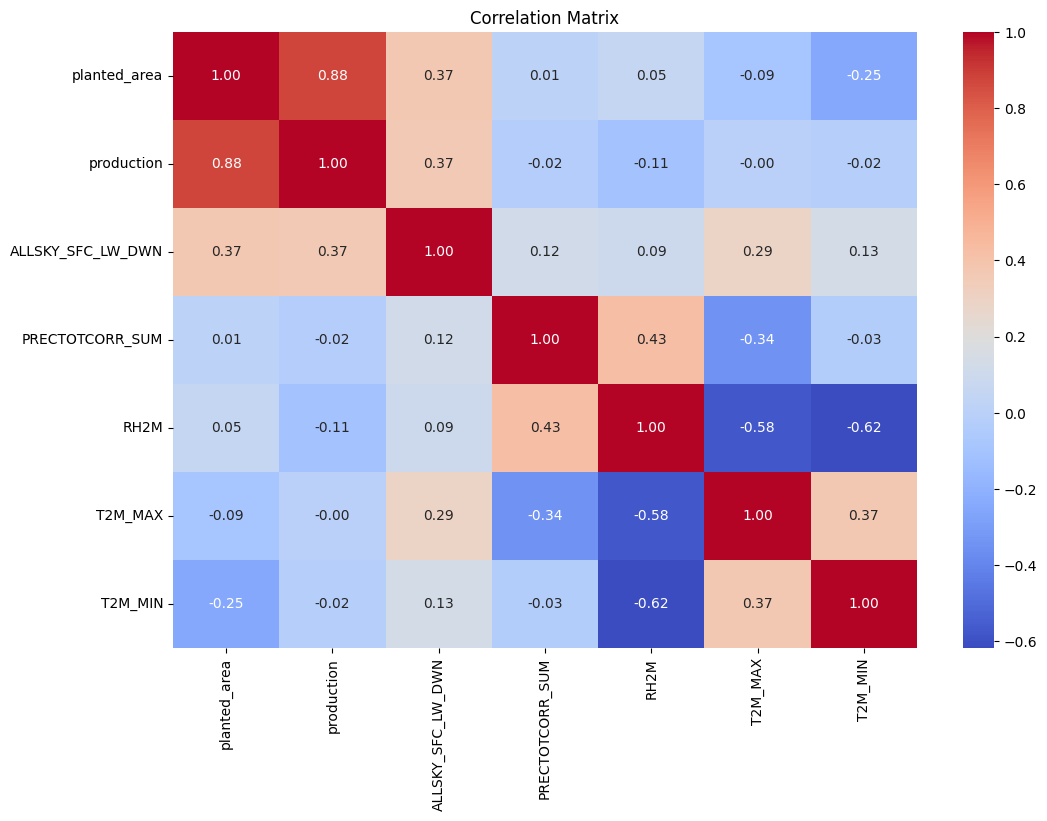

In [ ]:
# Visualize correlation matrix of numerical columns
# Select only numerical columns for correlation
numerical_cols = merged_df.select_dtypes(include=np.number).columns
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

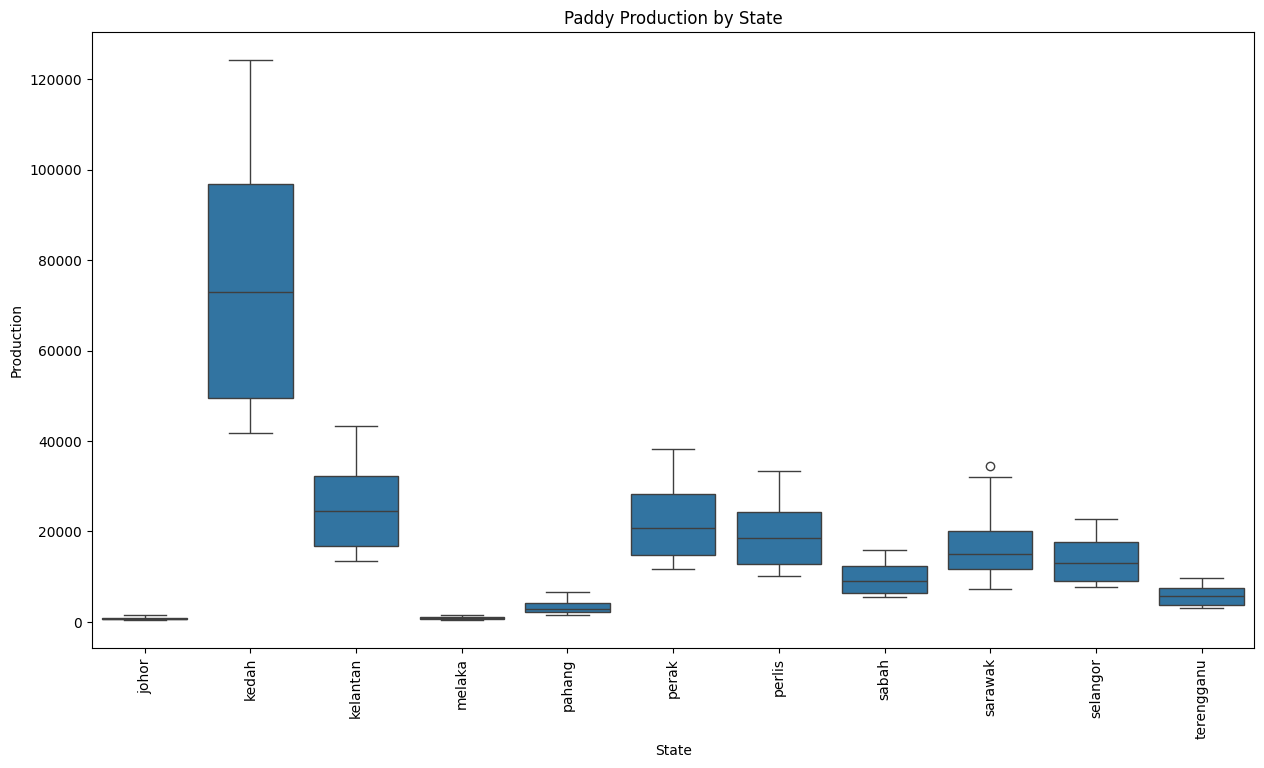

In [ ]:
# Box plots for production by state
plt.figure(figsize=(15, 8))
sns.boxplot(x='state', y='production', data=merged_df)
plt.title('Paddy Production by State')
plt.xlabel('State')
plt.ylabel('Production')
plt.xticks(rotation=90)
plt.show()

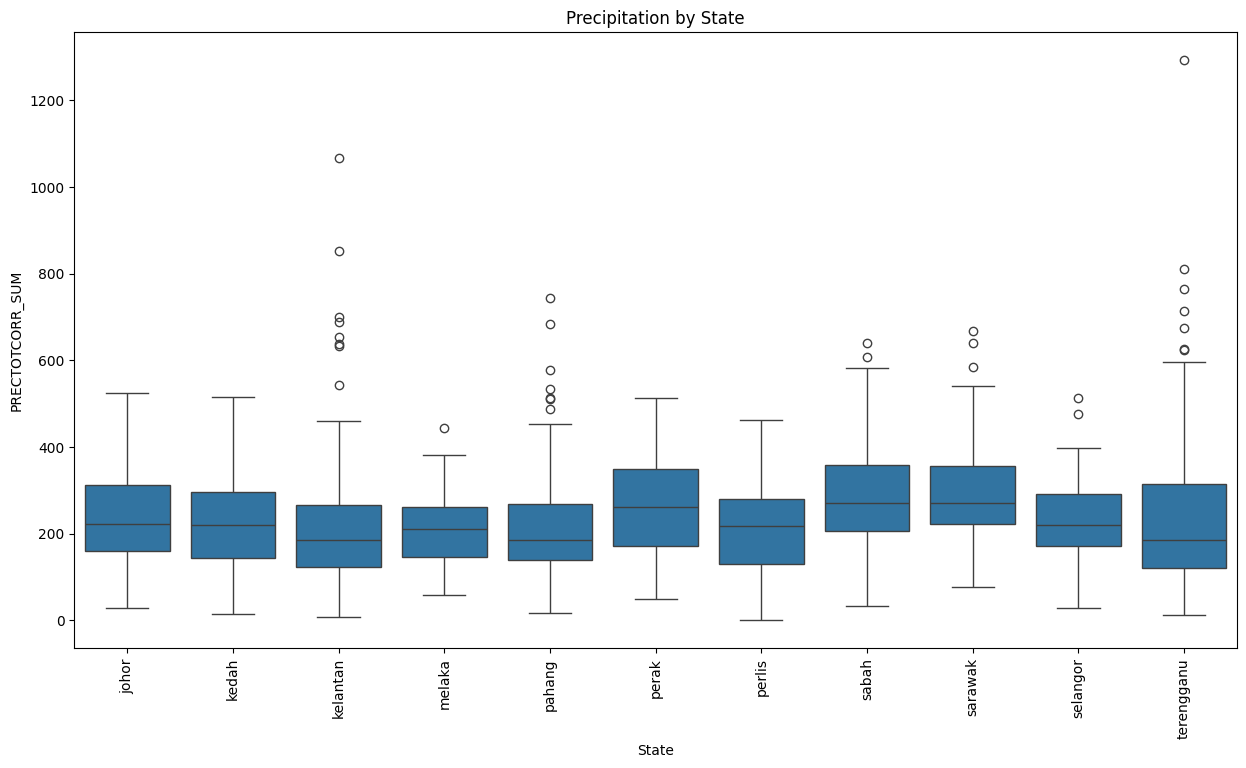

In [ ]:
# Box plots for weather parameters by state (example: PRECTOTCORR_SUM)
if 'PRECTOTCORR_SUM' in merged_df.columns:
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='state', y='PRECTOTCORR_SUM', data=merged_df)
    plt.title('Precipitation by State')
    plt.xlabel('State')
    plt.ylabel('PRECTOTCORR_SUM')
    plt.xticks(rotation=90)
    plt.show()

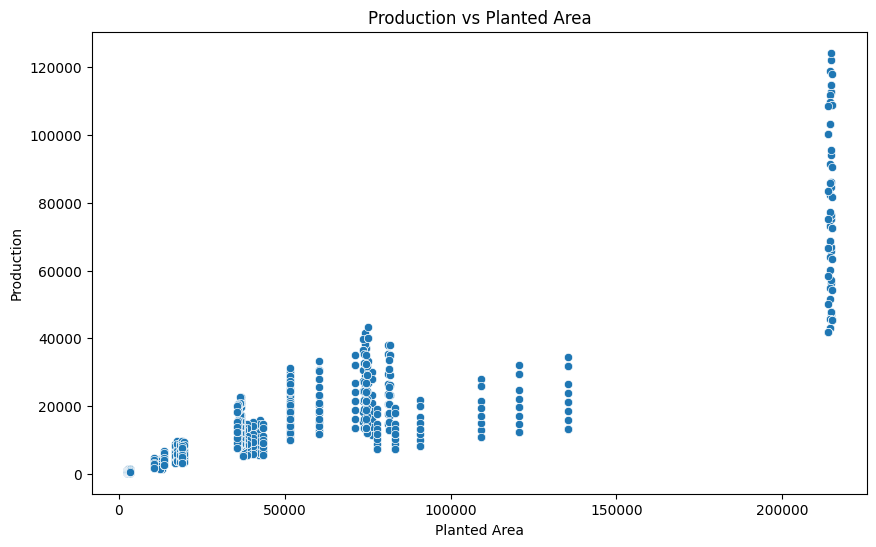

In [ ]:
# Scatter plot production vs planted area
plt.figure(figsize=(10, 6))
sns.scatterplot(x='planted_area', y='production', data=merged_df)
plt.title('Production vs Planted Area')
plt.xlabel('Planted Area')
plt.ylabel('Production')
plt.show()

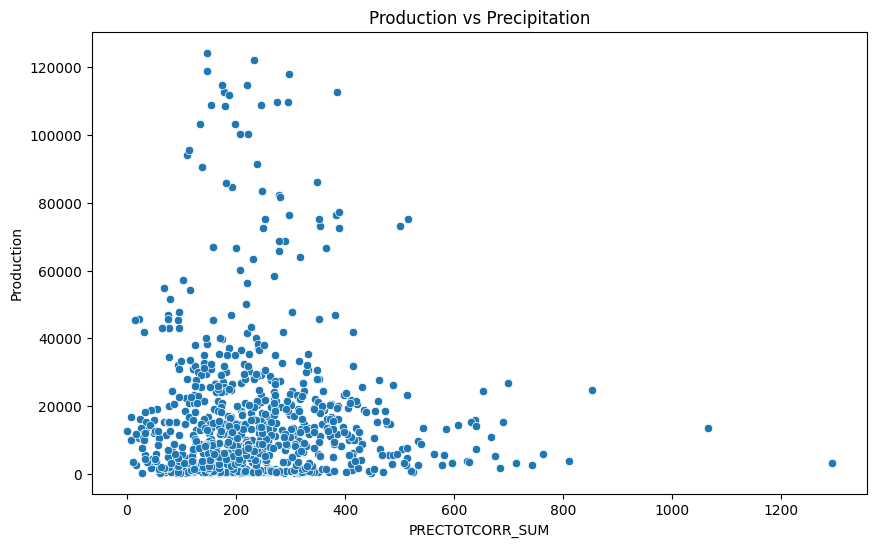

In [ ]:
# Scatter plot production vs a weather parameter (example: PRECTOTCORR_SUM)
if 'PRECTOTCORR_SUM' in merged_df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PRECTOTCORR_SUM', y='production', data=merged_df)
    plt.title('Production vs Precipitation')
    plt.xlabel('PRECTOTCORR_SUM')
    plt.ylabel('Production')
    plt.show()

In [ ]:
# Group by state and year to see annual trends
merged_df['year'] = merged_df['date'].dt.year
annual_state_summary = merged_df.groupby(['state', 'year']).agg({
    'production': 'sum',
    'planted_area': 'mean', # Assuming planted area is annual for simplicity
    'PRECTOTCORR_SUM': 'sum',
    'T2M_MAX': 'mean'
}).reset_index()

print("\nAnnual Summary by State:")
print(annual_state_summary.head())


Annual Summary by State:
   state  year  production  planted_area  PRECTOTCORR_SUM    T2M_MAX
0  johor  2017      8563.0        3000.0          2674.84  31.413333
1  johor  2018      9424.0        2866.0          2305.29  31.410833
2  johor  2019      7704.0        2555.0          1993.60  31.968333
3  johor  2020      7502.0        2547.0          2446.44  31.445833
4  johor  2021      9031.0        2505.0          3868.55  31.115833


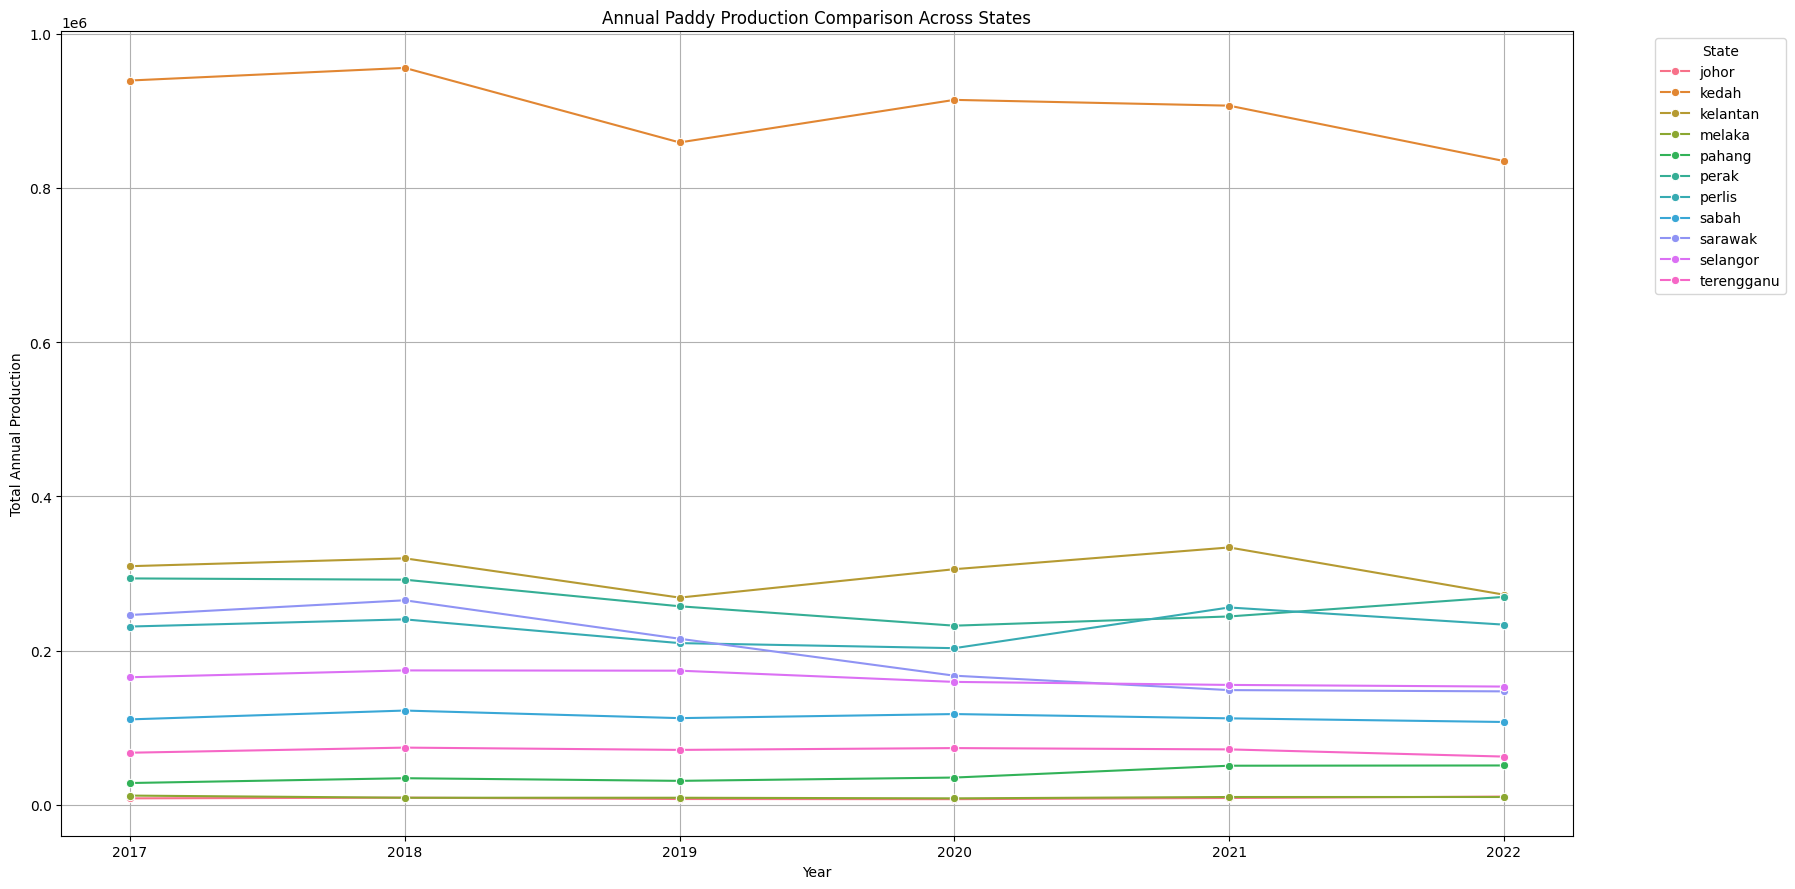

In [ ]:
import matplotlib.pyplot as plt
# Line plot comparing annual production across states
plt.figure(figsize=(18, 9))
sns.lineplot(data=annual_state_summary, x='year', y='production', hue='state', marker='o')
plt.title('Annual Paddy Production Comparison Across States')
plt.xlabel('Year')
plt.ylabel('Total Annual Production')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(annual_state_summary['year'].unique()) # Ensure all years are shown
plt.tight_layout()
plt.show()

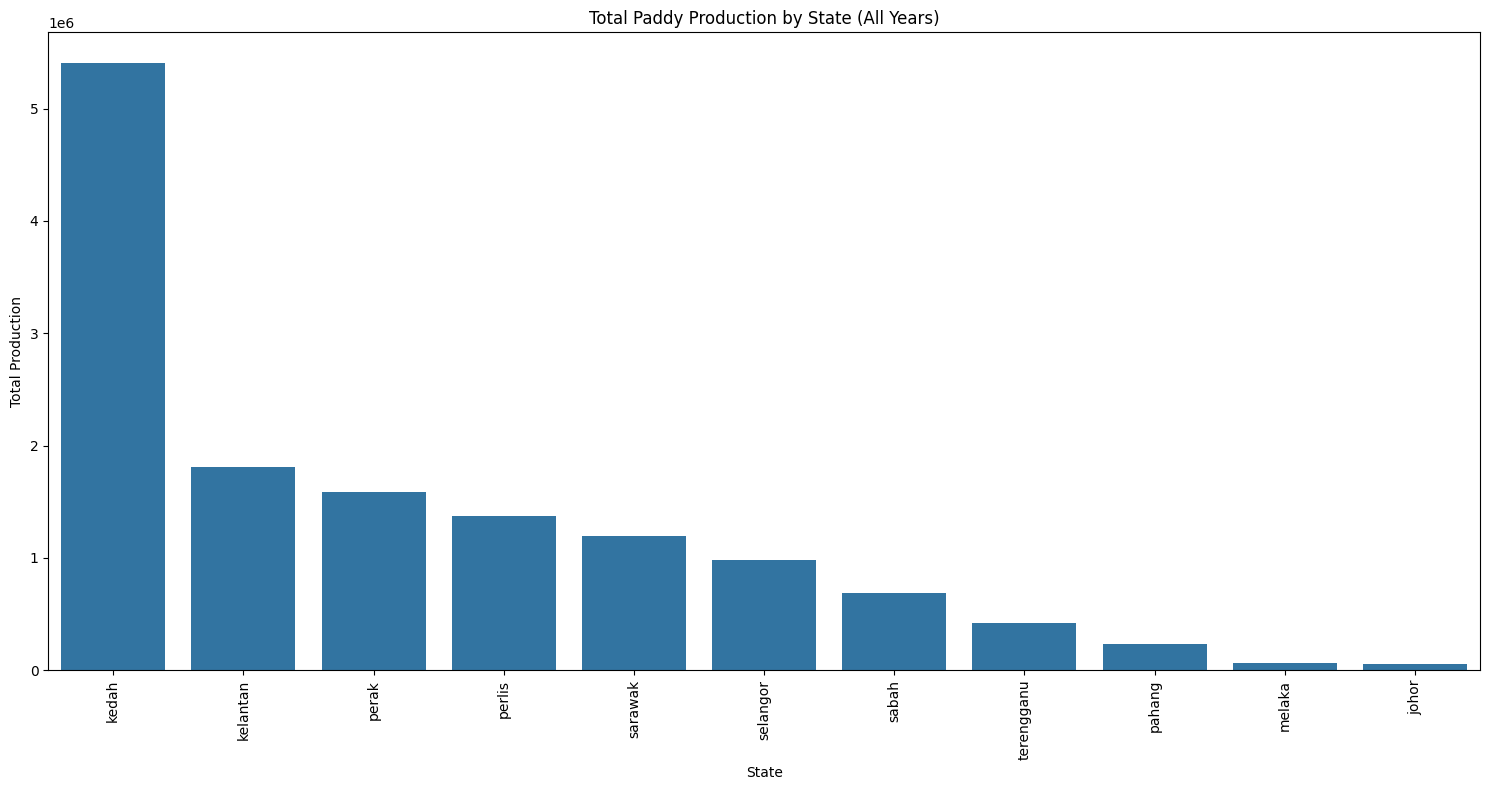

In [ ]:
# Bar plot comparing total production for each state over all years
total_production_by_state = merged_df.groupby('state')['production'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(x='state', y='production', data=total_production_by_state)
plt.title('Total Paddy Production by State (All Years)')
plt.xlabel('State')
plt.ylabel('Total Production')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

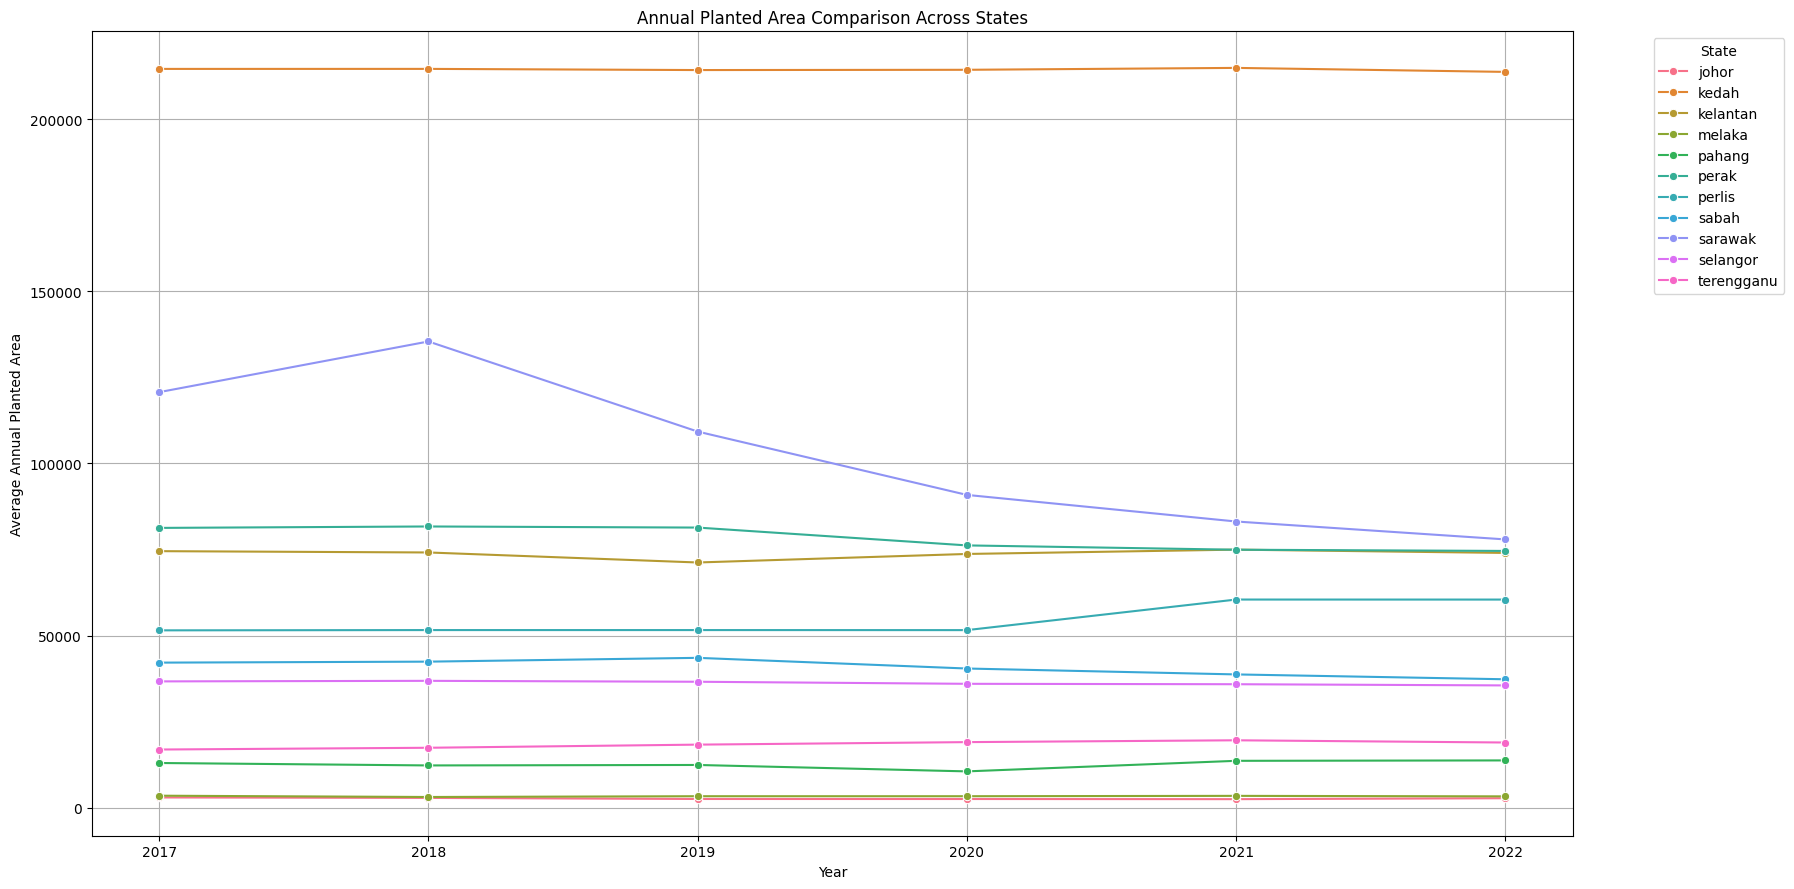

In [ ]:
# Line plot comparing annual planted area across states
plt.figure(figsize=(18, 9))
sns.lineplot(data=annual_state_summary, x='year', y='planted_area', hue='state', marker='o')
plt.title('Annual Planted Area Comparison Across States')
plt.xlabel('Year')
plt.ylabel('Average Annual Planted Area')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(annual_state_summary['year'].unique()) # Ensure all years are shown
plt.tight_layout()
plt.show()

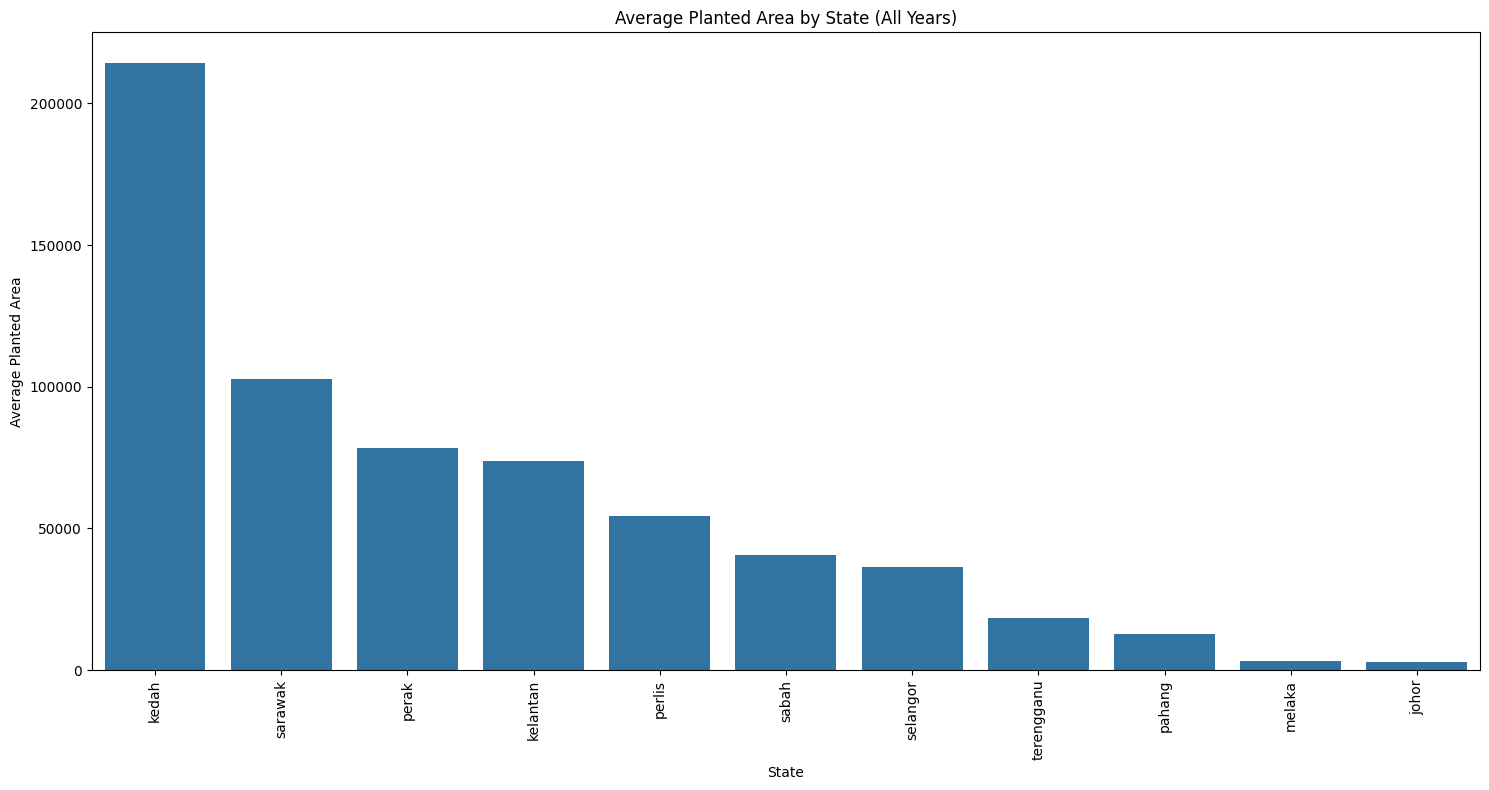

In [ ]:
# Bar plot comparing average planted area for each state over all years
average_planted_area_by_state = merged_df.groupby('state')['planted_area'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(x='state', y='planted_area', data=average_planted_area_by_state)
plt.title('Average Planted Area by State (All Years)')
plt.xlabel('State')
plt.ylabel('Average Planted Area')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
merged_df.head()

,state,date,crop_type,planted_area,production,ALLSKY_SFC_LW_DWN,PRECTOTCORR_SUM,RH2M,T2M_MAX,T2M_MIN,year
0,johor,2017-01-01,paddy,3000.0,428.15,35.68,288.36,88.86,30.55,23.27,2017
1,johor,2017-02-01,paddy,3000.0,428.15,35.85,169.65,88.09,30.84,22.39,2017
2,johor,2017-03-01,paddy,3000.0,513.78,36.05,192.78,86.75,31.06,22.54,2017
3,johor,2017-04-01,paddy,3000.0,599.41,36.47,210.91,85.57,31.64,23.98,2017
4,johor,2017-05-01,paddy,3000.0,685.04,36.82,251.21,87.80,31.52,24.90,2017


In [ ]:
import numpy as np
# Feature Engineering

# Create target variable 'yield'
merged_df['yield'] = merged_df['production'] / merged_df['planted_area']
# Handle potential division by zero if planted_area is 0
merged_df['yield'] = merged_df['yield'].replace([np.inf, -np.inf], np.nan)
merged_df['yield'] = merged_df['yield'].fillna(0) # or some other appropriate value

# Create lagged features for 'production' and 'yield'
# Define the number of lags
n_lags = 3

for lag in range(1, n_lags + 1):
    merged_df[f'production_lag_{lag}'] = merged_df.groupby('state')['production'].shift(lag)
    merged_df[f'yield_lag_{lag}'] = merged_df.groupby('state')['yield'].shift(lag)

# Drop rows with NaN values created by lagging (these are the first 'n_lags' rows for each state)
merged_df = merged_df.dropna(subset=[f'production_lag_{n_lags}', f'yield_lag_{n_lags}'])

# Create time-based features (e.g., month, year, week of year)
merged_df['month'] = merged_df['date'].dt.month
merged_df['year'] = merged_df['date'].dt.year
merged_df['week_of_year'] = merged_df['date'].dt.isocalendar().week.astype(int)

/tmp/ipython-input-42-3607401205.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['month'] = merged_df['date'].dt.month
/tmp/ipython-input-42-3607401205.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['year'] = merged_df['date'].dt.year
/tmp/ipython-input-42-3607401205.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [ ]:
# Sort the data by date to ensure chronological order
merged_df = merged_df.sort_values(by='date')

# Determine the split point. For time series, this is often a specific date or percentage of data.
# Let's use a percentage split, keeping the last portion for testing.
train_size_percentage = 0.8 # Use 80% of the data for training

# Calculate the number of rows for the training set
train_rows = int(len(merged_df) * train_size_percentage)

# Split the data
train_df = merged_df.iloc[:train_rows]
test_df = merged_df.iloc[train_rows:]

print(f"Original dataset shape: {merged_df.shape}")
print(f"Training dataset shape: {train_df.shape}")
print(f"Testing dataset shape: {test_df.shape}")

# Verify that the test set starts after the training set ends chronologically
print(f"Last date in training set: {train_df['date'].max()}")
print(f"First date in testing set: {test_df['date'].min()}")

Original dataset shape: (759, 20)
Training dataset shape: (607, 20)
Testing dataset shape: (152, 20)
Last date in training set: 2021-11-01 00:00:00
First date in testing set: 2021-11-01 00:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Separate features (X) and target (y) for training and testing
features = ['planted_area', 'PRECTOTCORR_SUM', 'T2M_MAX', 'production_lag_1', 'yield_lag_1',
            'production_lag_2', 'yield_lag_2', 'production_lag_3', 'yield_lag_3',
            'month', 'year', 'week_of_year'] # Include lagged features and time features

# Drop features that are not available for prediction or are targets
X_train = train_df[features]
y_train = train_df['production']
X_test = test_df[features]
y_test = test_df['production']

# Handle categorical feature 'state' if needed. For these models, we'll use numerical features only.
# One-hot encoding is an option if state is considered a feature, but let's start with numerical only.

# Scale numerical features. This is important for SVR and LSTM, less critical but still beneficial for Random Forest.
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Convert scaled arrays back to DataFrames with original column names (optional but good practice)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)
y_train_scaled_series = pd.Series(y_train_scaled.flatten(), index=y_train.index)
y_test_scaled_series = pd.Series(y_test_scaled.flatten(), index=y_test.index)

In [ ]:
# --------------------------------------------------
# 1. Random Forest Regression
# --------------------------------------------------
print("\n--- Random Forest Regression ---")
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled_df, y_train_scaled_series) # Use scaled data for consistency, though RF is less sensitive

# Make predictions
y_pred_rf_scaled = rf_model.predict(X_test_scaled_df)

# Inverse transform predictions to original scale
y_pred_rf = scaler_y.inverse_transform(y_pred_rf_scaled.reshape(-1, 1)).flatten()

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"Random Forest R2 Score: {r2_rf:.4f}")


--- Random Forest Regression ---
Random Forest MSE: 7628189.4167
Random Forest RMSE: 2761.9177
Random Forest R2 Score: 0.9796


In [ ]:
# --------------------------------------------------
# 2. Support Vector Regression (SVR)
# --------------------------------------------------
print("\n--- Support Vector Regression ---")
from sklearn.svm import SVR

# Initialize and train the model
# Use scaled data as SVR is sensitive to the scale of features
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1) # Example parameters, tune as needed
svr_model.fit(X_train_scaled, y_train_scaled.flatten()) # SVR expects 1D target array

# Make predictions
y_pred_svr_scaled = svr_model.predict(X_test_scaled)

# Inverse transform predictions to original scale
y_pred_svr = scaler_y.inverse_transform(y_pred_svr_scaled.reshape(-1, 1)).flatten()

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR MSE: {mse_svr:.4f}")
print(f"SVR RMSE: {rmse_svr:.4f}")
print(f"SVR R2 Score: {r2_svr:.4f}")


--- Support Vector Regression ---
SVR MSE: 19690735.8984
SVR RMSE: 4437.4245
SVR R2 Score: 0.9473


In [ ]:
# --------------------------------------------------
# 3. Long Short-Term Memory (LSTM) - using Keras/TensorFlow
# --------------------------------------------------
print("\n--- LSTM Regression ---")
# Install TensorFlow if not already installed
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow
    import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

# Reshape data for LSTM: [samples, timesteps, features]
# Here, samples = number of data points, timesteps = 1 (predicting based on current features), features = number of features
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"X_test_lstm shape: {X_test_lstm.shape}")

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) # 50 units, input shape is (timesteps, features)
lstm_model.add(Dropout(0.2)) # Add dropout for regularization
lstm_model.add(Dense(1)) # Output layer with 1 unit for regression

lstm_model.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss

# Define early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Train the model
# Use validation split for early stopping
history = lstm_model.fit(X_train_lstm, y_train_scaled,
                         epochs=100, # Increase epochs, early stopping will stop it
                         batch_size=32,
                         validation_split=0.2, # Use 20% of training data for validation
                         callbacks=[early_stopping],
                         verbose=0) # Set verbose to 1 to see training progress

print("LSTM model training finished.")

# Make predictions
y_pred_lstm_scaled = lstm_model.predict(X_test_lstm)

# Inverse transform predictions to original scale
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled).flatten()

# Evaluate the model
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM MSE: {mse_lstm:.4f}")
print(f"LSTM RMSE: {rmse_lstm:.4f}")
print(f"LSTM R2 Score: {r2_lstm:.4f}")


--- LSTM Regression ---
X_train_lstm shape: (607, 1, 12)
X_test_lstm shape: (152, 1, 12)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 99: early stopping
Restoring model weights from the end of the best epoch: 89.
LSTM model training finished.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
LSTM MSE: 5242600.5277
LSTM RMSE: 2289.6726
LSTM R2 Score: 0.9860


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Store results
results = {
    'Random Forest': {'MSE': mse_rf, 'RMSE': rmse_rf, 'R2': r2_rf},
    'SVR': {'MSE': mse_svr, 'RMSE': rmse_svr, 'R2': r2_svr},
    'LSTM': {'MSE': mse_lstm, 'RMSE': rmse_lstm, 'R2': r2_lstm}
}

# Create a DataFrame for comparison
results_df = pd.DataFrame.from_dict(results, orient='index')

print("\n--- Model Comparison ---")
print(results_df)


--- Model Comparison ---
                        MSE         RMSE        R2
Random Forest  7.628189e+06  2761.917706  0.979581
SVR            1.969074e+07  4437.424467  0.947291
LSTM           5.242601e+06  2289.672581  0.985966


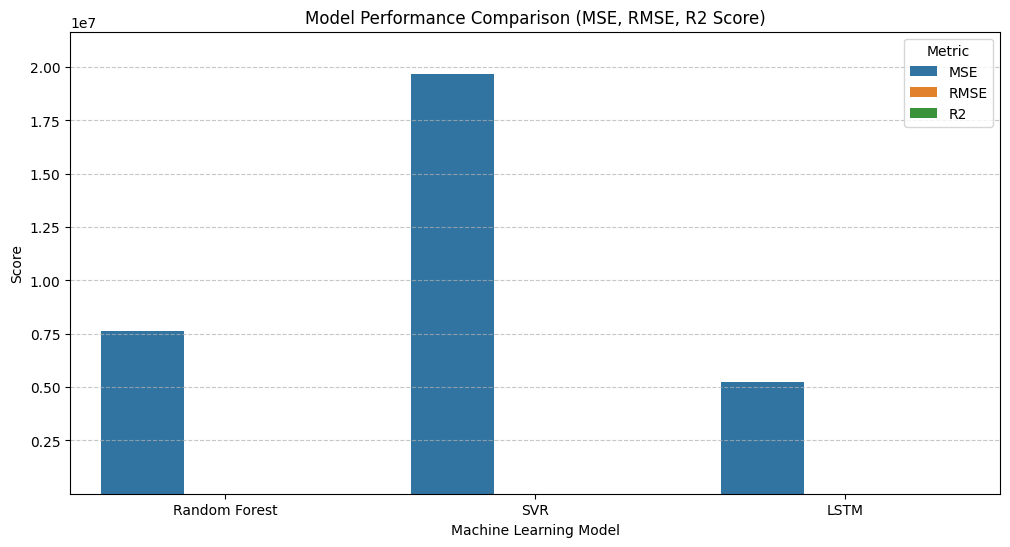

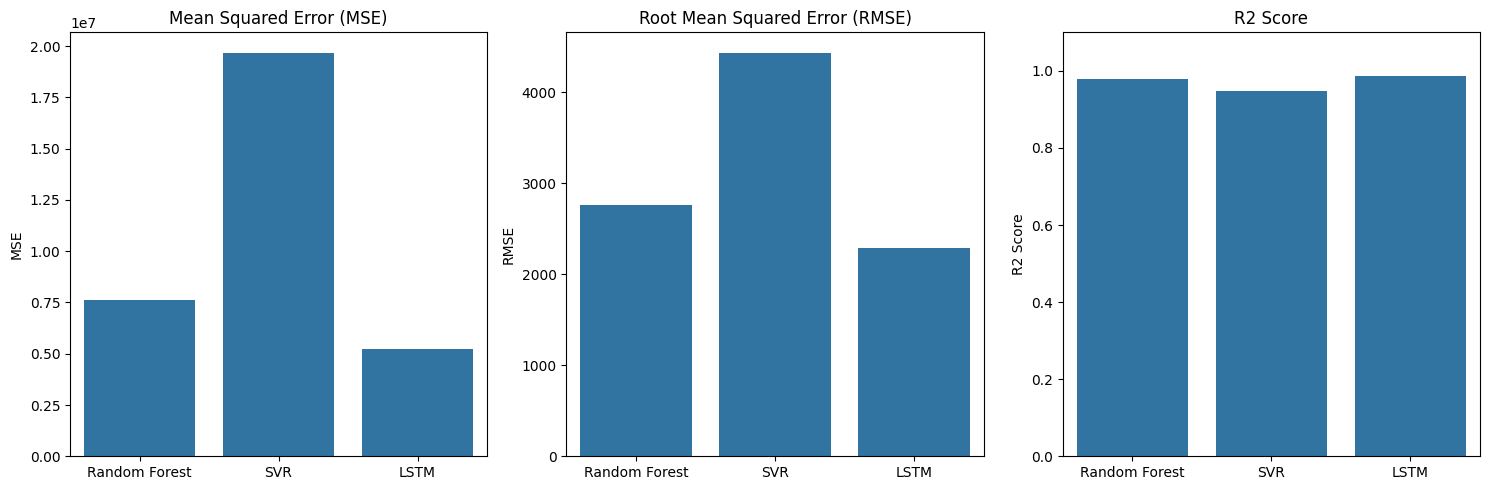

In [ ]:
import matplotlib.pyplot as plt
# Melt the results DataFrame to a long format for easier plotting
results_melted = results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
results_melted.rename(columns={'index': 'Model'}, inplace=True)

# Plotting the comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=results_melted)
plt.title('Model Performance Comparison (MSE, RMSE, R2 Score)')
plt.ylabel('Score')
plt.xlabel('Machine Learning Model')
plt.ylim(min(results_melted['Value']) * 0.9, max(results_melted['Value']) * 1.1) # Adjust y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Optional: Plot specific metrics separately for clarity
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x='index', y='MSE', data=results_df.reset_index())
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xlabel('')
plt.xticks(rotation=0)

plt.subplot(1, 3, 2)
sns.barplot(x='index', y='RMSE', data=results_df.reset_index())
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xlabel('')
plt.xticks(rotation=0)

plt.subplot(1, 3, 3)
sns.barplot(x='index', y='R2', data=results_df.reset_index())
plt.title('R2 Score')
plt.ylabel('R2 Score')
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylim(0, 1.1) # R2 is usually between 0 and 1

plt.tight_layout()
plt.show()

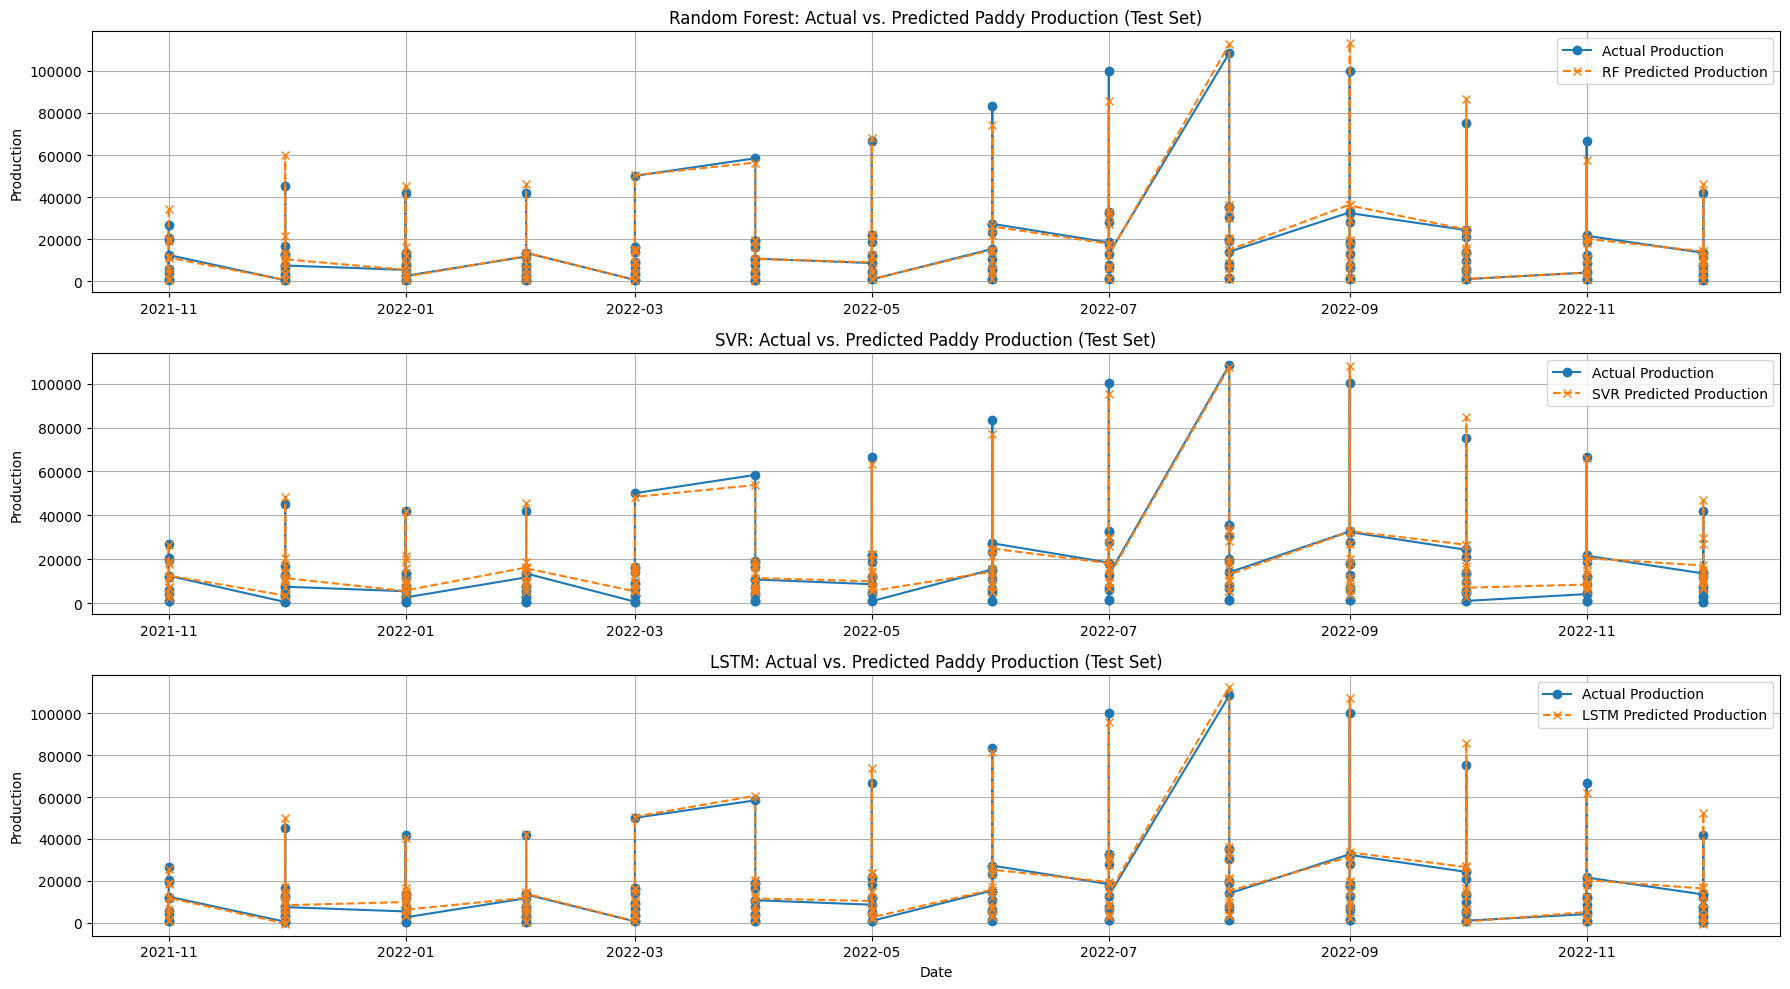

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Combine actual and predicted values for plotting
comparison_df = pd.DataFrame({
    'Date': test_df['date'],
    'Actual Production': y_test,
    'RF Predicted Production': y_pred_rf,
    'SVR Predicted Production': y_pred_svr,
    'LSTM Predicted Production': y_pred_lstm
})

# Sort by date to ensure chronological plotting
comparison_df = comparison_df.sort_values(by='Date')

# Plotting Actual vs. Predicted Production for each model
plt.figure(figsize=(18, 10))

plt.subplot(3, 1, 1) # 3 rows, 1 column, 1st plot
plt.plot(comparison_df['Date'], comparison_df['Actual Production'], label='Actual Production', marker='o', linestyle='-')
plt.plot(comparison_df['Date'], comparison_df['RF Predicted Production'], label='RF Predicted Production', marker='x', linestyle='--')
plt.title('Random Forest: Actual vs. Predicted Paddy Production (Test Set)')
plt.ylabel('Production')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2) # 3 rows, 1 column, 2nd plot
plt.plot(comparison_df['Date'], comparison_df['Actual Production'], label='Actual Production', marker='o', linestyle='-')
plt.plot(comparison_df['Date'], comparison_df['SVR Predicted Production'], label='SVR Predicted Production', marker='x', linestyle='--')
plt.title('SVR: Actual vs. Predicted Paddy Production (Test Set)')
plt.ylabel('Production')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3) # 3 rows, 1 column, 3rd plot
plt.plot(comparison_df['Date'], comparison_df['Actual Production'], label='Actual Production', marker='o', linestyle='-')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted Production'], label='LSTM Predicted Production', marker='x', linestyle='--')
plt.title('LSTM: Actual vs. Predicted Paddy Production (Test Set)')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

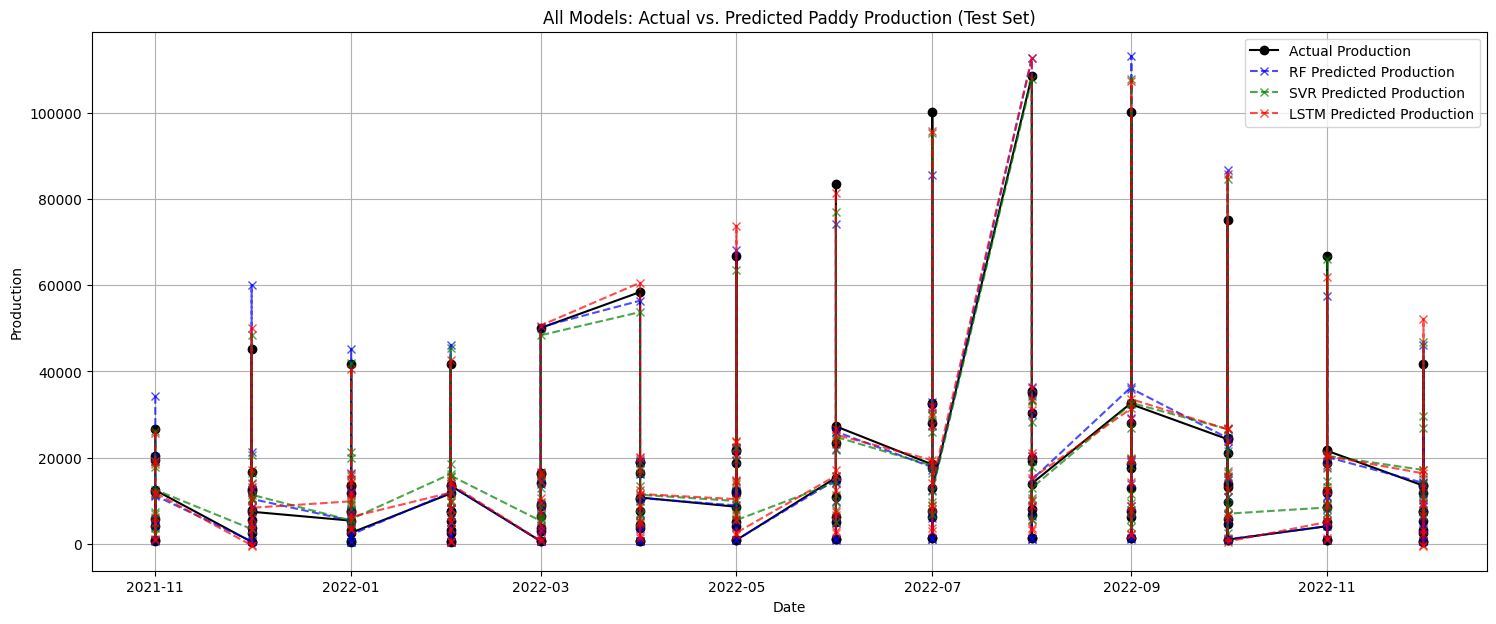

In [ ]:
# Plot the predictions of all models against actual on a single plot for direct visual comparison
plt.figure(figsize=(18, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual Production'], label='Actual Production', marker='o', linestyle='-', color='black')
plt.plot(comparison_df['Date'], comparison_df['RF Predicted Production'], label='RF Predicted Production', marker='x', linestyle='--', color='blue', alpha=0.7)
plt.plot(comparison_df['Date'], comparison_df['SVR Predicted Production'], label='SVR Predicted Production', marker='x', linestyle='--', color='green', alpha=0.7)
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted Production'], label='LSTM Predicted Production', marker='x', linestyle='--', color='red', alpha=0.7)
plt.title('All Models: Actual vs. Predicted Paddy Production (Test Set)')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

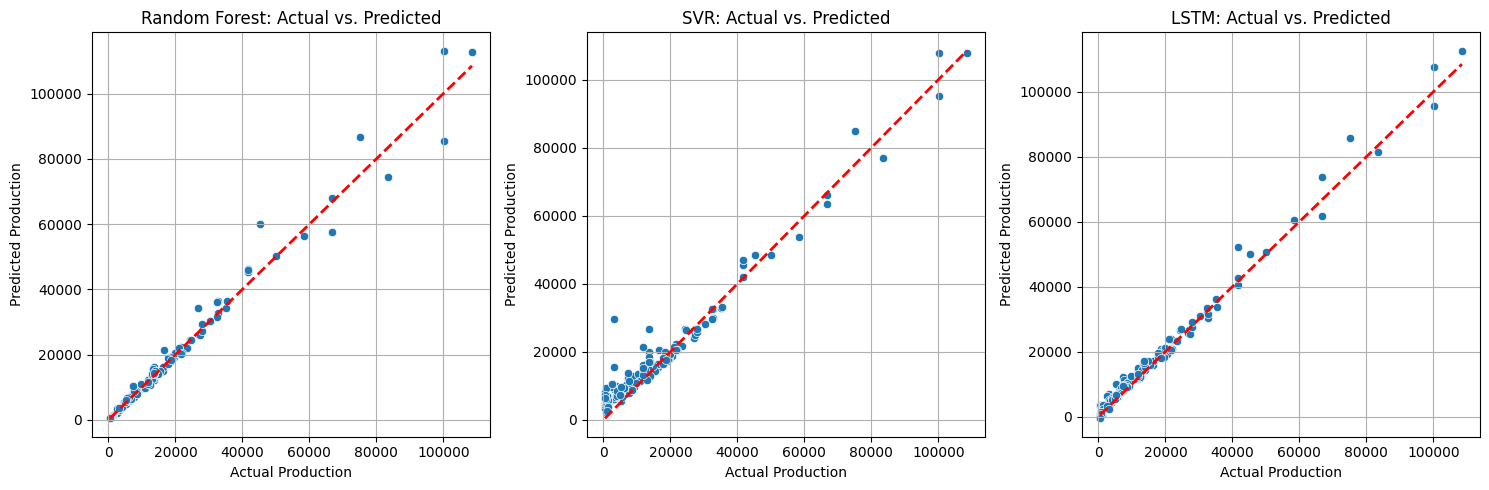

In [ ]:
# Scatter plot of Actual vs. Predicted values for each model
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='Actual Production', y='RF Predicted Production', data=comparison_df)
plt.plot([comparison_df['Actual Production'].min(), comparison_df['Actual Production'].max()],
         [comparison_df['Actual Production'].min(), comparison_df['Actual Production'].max()],
         'r--', lw=2) # Add a diagonal line for perfect prediction
plt.title('Random Forest: Actual vs. Predicted')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(x='Actual Production', y='SVR Predicted Production', data=comparison_df)
plt.plot([comparison_df['Actual Production'].min(), comparison_df['Actual Production'].max()],
         [comparison_df['Actual Production'].min(), comparison_df['Actual Production'].max()],
         'r--', lw=2) # Add a diagonal line for perfect prediction
plt.title('SVR: Actual vs. Predicted')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(x='Actual Production', y='LSTM Predicted Production', data=comparison_df)
plt.plot([comparison_df['Actual Production'].min(), comparison_df['Actual Production'].max()],
         [comparison_df['Actual Production'].min(), comparison_df['Actual Production'].max()],
         'r--', lw=2) # Add a diagonal line for perfect prediction
plt.title('LSTM: Actual vs. Predicted')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.grid(True)

plt.tight_layout()
plt.show()